In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 25 14:15:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# pip install --user --upgrade tensorflow-model-optimization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
# import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras import regularizers
# from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing Dataset

In [5]:
training = '/content/drive/MyDrive/Dataset'
# validation = '/content/drive/MyDrive/Dataset/No DR'
# testing = '/content/drive/MyDrive/Test'

train_batches = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, vertical_flip=True, validation_split=0.2, rescale=1./255).flow_from_directory(directory=training, target_size=(224,224), class_mode='categorical', batch_size=64, subset='training')
valid_batches = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, vertical_flip=True, validation_split=0.2, rescale=1./255).flow_from_directory(directory=training, target_size=(224,224), class_mode = 'categorical', batch_size=64, subset='validation')
# test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=testing, target_size=(224,224), batch_size=64, class_mode = 'binary', shuffle=False)

Found 3325 images belonging to 6 classes.
Found 827 images belonging to 6 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # img = img.swapaxes(0,1)
        # img = img.swapaxes(1,2)
        ax.imshow(img)       
        ax.axis('off')
    plt.tight_layout()
    plt.show()

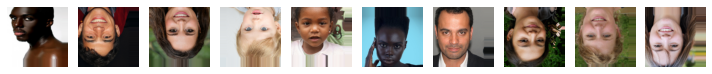

In [8]:
plotImages(imgs)

## Defining Model

In [9]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 4s 0us/step


In [10]:
for layer in vgg16_model.layers:
        layer.trainable=False

In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
model.add(Dense(units=6, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Compile Model

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Callbacks

In [15]:
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True, verbose=1)
# scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0003 * 10 ** (epoch / 100))
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1.1 , patience=5, verbose=1)

## Training and Validating Model

In [16]:
history = model.fit(x=train_batches,
                    steps_per_epoch=train_batches.samples // 64,
                    validation_data=valid_batches,
                    validation_steps=valid_batches.samples // 64,
                    epochs=40,
                    verbose=1,
                    callbacks=[stopping]
)

Epoch 1/40
51/51 [==============================] - 2152s 42s/step - loss: 1.6516 - accuracy: 0.3554 - val_loss: 1.4037 - val_accuracy: 0.4466
Epoch 2/40
51/51 [==============================] - 148s 3s/step - loss: 1.2772 - accuracy: 0.5186 - val_loss: 1.3425 - val_accuracy: 0.4518
Epoch 3/40
51/51 [==============================] - 148s 3s/step - loss: 1.1427 - accuracy: 0.5738 - val_loss: 1.3105 - val_accuracy: 0.4492
Epoch 4/40
51/51 [==============================] - 148s 3s/step - loss: 1.0534 - accuracy: 0.6010 - val_loss: 1.1914 - val_accuracy: 0.5299
Epoch 5/40
51/51 [==============================] - 148s 3s/step - loss: 1.0129 - accuracy: 0.6225 - val_loss: 1.1777 - val_accuracy: 0.5169
Epoch 6/40
51/51 [==============================] - 148s 3s/step - loss: 0.9667 - accuracy: 0.6369 - val_loss: 1.1661 - val_accuracy: 0.5104
Epoch 7/40
51/51 [==============================] - 148s 3s/step - loss: 0.9540 - accuracy: 0.6326 - val_loss: 1.1062 - val_accuracy: 0.5430
Epoch 8/40


## Displaying Training and Validation Graphs

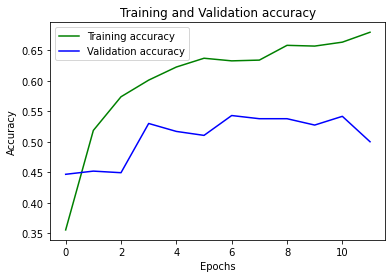

In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

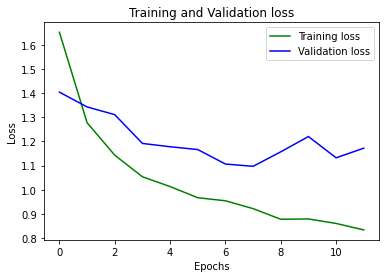

In [18]:
train_acc = history.history['loss']
val_acc = history.history['val_loss']
plt.plot(train_acc, 'g', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## ROC Curve

In [19]:
# make a prediction
# y_pred_keras = model.predict_generator(test_batches, verbose=1)
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_batches.classes, y_pred_keras)
# auc_keras = auc(fpr_keras, tpr_keras)
# auc_keras

In [20]:
# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

## Testing Model

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
test_imgs, test_labels = next(valid_batches)
predictions = model.predict(x=valid_batches, steps=len(valid_batches), verbose=0)

In [23]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [24]:
valid_batches.class_indices

{'Browned Caramel': 0,
 'Cacao Black Skin': 1,
 'Dark Medium': 2,
 'Espresso Milk Chocolate': 3,
 'Fair': 4,
 'Light Medium': 5}

Confusion matrix, without normalization
[[ 0  5  2 23 17 20]
 [ 0  6  1 35 24 25]
 [ 0  7  5 40 30 26]
 [ 1 12  9 85 42 56]
 [ 0 20  6 77 52 45]
 [ 0 13  8 65 39 31]]


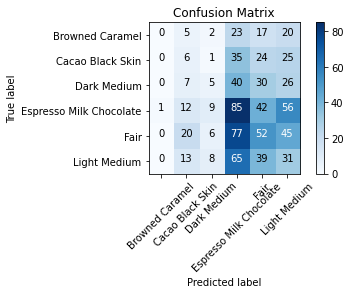

In [28]:
cm_plot_labels = ['Browned Caramel','Cacao Black Skin', 'Dark Medium', 'Espresso Milk Chocolate', 'Fair', 'Light Medium']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Save TfLite Model

In [26]:
model.save('vgg_model')

In [27]:
# path to the SavedModel directory
saved_model_dir = 'vgg_model'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('skinTone.tflite', 'wb') as f:
  f.write(tflite_model)